In [1]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import os
import glob
import time
from datetime import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from backbone.mobilenetv3 import mobilenetv3_large
from backbones.mobilenetv3_pytorch import mobilenet_v3_large
from backbones.mobilenetv3_pytorch import mobilenet_v3_small

from backbones import resnet
from backbones import regnet
from backbones import efficientnet

from typing import Tuple
from sklearn.metrics import f1_score, accuracy_score, precision_score
import scikitplot as skplt
import pandas as pd

## Vairiable

In [2]:
path_data="/media/msi/Silicon/project/person_lying_down/data_set/trranning_sessions/№2_feb_24_2022/"



weights="/media/msi/Silicon/project/person_lying_down/train_scripts/train_image_classifer_optuna/RESULTS/lying_ornot_2022-03-29_17-35-34_resnet18/z6jxs9na_batch=1344_lr=0.00082_epochs=350_resolush=224/checkpoint_0003.pth"
# weights="/media/msi/Silicon/project/person_lying_down/train_scripts/train_image_classifer_optuna/RESULTS/lying_ornot_2022-03-22_15-59-24_resnet18/ougz1eor_batch=448_lr=0.00281_epochs=80_resolush=336/checkpoint_0000.pth"


# '''
# ['mobilenet_v3_large','mobilenet_v3_small','mobilenet_v2', 
# 'resnet18', 'resnet34', 'resnet50',
# 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2',
# 'regnet_x_400mf','regnet_x_800mf','regnet_x_1_6gf','regnet_x_3_2gf']
# '''


batch_train=64
batch_valid=64
batch_test=64

# device = "cuda:0"

csv_append="/media/msi/Silicon/project/person_lying_down/train_scripts/train_image_classifer_optuna/RESULTS/summarize.csv" # path for saving all results

# Create dict for summarize experiment

In [4]:
# Define init colums

colums="hash_exprmnt;backbone;batch_size;lr;epochs;resolush;Loss_train;Accuracy_train;Precision_train;f1_score_train;Time_train;infer_batch_train;FPS_train;Loss_valid;Accuracy_valid;Precision_valid;f1_score_valid;Time_valid;infer_batch_valid;FPS_valid;Loss_test;Accuracy_test;Precision_test;f1_score_test;Time_test;infer_batch_test;FPS_test"
colums_dict=dict()
for i in colums.split(";"):
    colums_dict[i]=None
colums_dict

# Create csv-file for summarize
if not os.path.isfile(csv_append):
    with open(csv_append, "w") as file:
        file.write(colums+'\n')

# Read csv experiment and turn it into dictionary
param_exp=os.path.join(weights[:weights.rfind("/")],"param_expirement.csv")
df = pd.read_csv (param_exp,sep="\t") #
param_exp=dict()
for i in df.columns[1:]:
    param_exp[i]=df.iloc[0][i]

# Add from csv filex experiments-trial to dictinary    
for i in param_exp:
    colums_dict[i]=param_exp[i]
colums_dict


resolush=int(colums_dict['resolush'])
backbone=colums_dict['backbone']

print("resolush",resolush)
print("backbone",backbone)

colums_dict

resolush 224
backbone resnet18


{'hash_exprmnt': 'z6jxs9na',
 'backbone': 'resnet18',
 'batch_size': 1344.0,
 'lr': 0.00082,
 'epochs': 350.0,
 'resolush': 224.0,
 'Loss_train': None,
 'Accuracy_train': None,
 'Precision_train': None,
 'f1_score_train': None,
 'Time_train': None,
 'infer_batch_train': None,
 'FPS_train': None,
 'Loss_valid': None,
 'Accuracy_valid': None,
 'Precision_valid': None,
 'f1_score_valid': None,
 'Time_valid': None,
 'infer_batch_valid': None,
 'FPS_valid': None,
 'Loss_test': None,
 'Accuracy_test': None,
 'Precision_test': None,
 'f1_score_test': None,
 'Time_test': None,
 'infer_batch_test': None,
 'FPS_test': None}

## Parse variable

In [5]:
######## Device check ########

if not 'device' in locals():
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

print("Device: ", device)

Device:  cuda:0


In [6]:
######## Create classes ########

classes = os.listdir(path_data)
classes.sort()
classes
print(f'Classes : {classes}')

Classes : ['lying', 'stand']


In [7]:
########  Choose backone ########

if backbone == 'mobilenet_v2':
    model = mobilenet_v2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
elif backbone == 'mobilenet_v3_large':
    model = mobilenet_v3_large()
    model.load_state_dict(torch.load('./pretrain_weight/mobilenet_v3_large-8738ca79.pth'))
    model.classifier[3]=nn.Linear(model.classifier[3].in_features, len(classes))
elif backbone == 'mobilenet_v3_small':
    model = mobilenet_v3_small()
    model.load_state_dict(torch.load('./pretrain_weight/mobilenet_v3_small-047dcff4.pth'))
    model.classifier[3]=nn.Linear(model.classifier[3].in_features, len(classes))
elif backbone in ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2']:
    model = efficientnet.__dict__[backbone](pretrained=False)
    model.classifier[1]=nn.Linear(in_features=model.classifier[1].in_features, out_features=len(classes), bias=True)
elif backbone in ['regnet_x_400mf','regnet_x_800mf','regnet_x_1_6gf','regnet_x_3_2gf']:
    model = regnet.__dict__[backbone](pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, out_features=len(classes), bias=True)
elif backbone in ['resnet18', 'resnet34', 'resnet50']:
    model = resnet.__dict__[backbone](pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, len(classes))

########  Load weights ########
model.load_state_dict(torch.load(weights))
model.to(device)
model.share_memory()
model.eval()

# print(model)

print('Backbone: {}'.format(backbone))

Backbone: resnet18


__1.1 Data_sets__

In [8]:
class DS(Dataset):
    def __init__(self, images: list, classes: list, use_albu: bool = False):
        self.images = images
        self.classes = classes
        self.use_albu = use_albu

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        img = Image.open(self.images[idx]).convert('RGB')
        img = torchvision.transforms.Resize((resolush, resolush))(img)
        img = torchvision.transforms.ToTensor()(img)
        img = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )(img)

        c = os.path.dirname(self.images[idx]).split('/')[-2]

        return img, self.images[idx], self.classes.index(c)

    def __len__(self) -> int:
        return len(self.images) 

__1.2 Data_loader__

In [9]:
train_images = []
valid_images = []
test_images = []
sub_dirs = ['train', 'valid', 'test']


for c in classes:
    for idx, sd in enumerate(sub_dirs):
        tmp = glob.glob(f'{path_data}/{c}/{sd}/*.jpg')
        tmp += glob.glob(f'{path_data}/{c}/{sd}/*.png')
        tmp += glob.glob(f'{path_data}/{c}/{sd}/*.JPG')
        tmp += glob.glob(f'{path_data}/{c}/{sd}/*.JPEG')
        tmp += glob.glob(f'{path_data}/{c}/{sd}/*.PNG')

        if idx == 0:
            for t in tmp:
                train_images.append(t)
        elif idx == 1:
            for t in tmp:
                valid_images.append(t)
        elif idx == 2:
            for t in tmp:
                test_images.append(t)
                
                
train_dataset = DS(train_images, classes=classes, use_albu=False)
valid_dataset = DS(valid_images, classes=classes, use_albu=False)
test_dataset = DS(test_images, classes=classes, use_albu=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_train, shuffle=False,num_workers=16, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_valid, shuffle=False,num_workers=16, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_test, shuffle=False,num_workers=16, pin_memory=True)

datalodaer_list={'test':test_dataloader,'valid':valid_dataloader,'train':train_dataloader}

__3 Inference on all sets for test__

In [10]:
criteria = nn.CrossEntropyLoss()
sft_mx = nn.Softmax(dim=1)

all_set_list_wrong={'test':[],'valid':[],'train':[]}
all_set_list_right={'test':[],'valid':[],'train':[]}

all_set_list_true={'test':[],'valid':[],'train':[]}
all_set_list_pred={'test':[],'valid':[],'train':[]}


for key, value in datalodaer_list.items():
    
    avg_loss = 0
    avg_acc = 0
    
    avg_prec = 0
    avg_f1 = 0

    list_wrong=[]
    list_wrong_tmp=[]
    list_wrong_prob=[]

    list_right=[]
    list_right_tmp=[]
    list_right_prob=[]
    
    
#     list_pred=[]
#     list_true=[]
    
#     duration=timedelta(hours=0, minutes=0, seconds=0, microseconds=0)
    duration=0
    
    for imgs, imgs_paths, labels in value:
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            start_time = time.time()
            
#             start = datetime.now().time()
            out = model(imgs)
#             end = datetime.now().time()
            end_time = time.time()
#             print(start_time,end_time)
#             print(end_time-start_time, batch)
#             print( (end_time-start_time)/batch)
#             print( "fps", batch/(end_time-start_time))
            
            loss = criteria(out, labels)

        # Count time duration    
#         t1 = timedelta(hours=start.hour, minutes=start.minute, seconds=start.second,  microseconds=start.microsecond)
#         t2 = timedelta(hours=end.hour,   minutes=end.minute,  seconds=end.second,  microseconds=end.microsecond) 
#         duration = duration+t2 - t1    
        duration=duration+end_time-start_time
        
        avg_loss += round(loss.item(), 3)

        tmp_sftmx_all=torch.max(sft_mx(out), dim=1)

        out=tmp_sftmx_all[1].cpu().numpy()
        tmp_sftmx=tmp_sftmx_all[0].cpu().numpy()
        labels=labels.cpu().numpy()
        
        # Создаём словарь списков для ground_truth для каждого Dataset: train test valid есть ответы true и predict, содаём для confusion matrix
        all_set_list_true[key]=all_set_list_true[key]+list(labels)
        # Создаём словарь списков ответов модели для каждого Dataset: train test valid есть ответы true и predict, содаём для confusion matrix
        all_set_list_pred[key]=all_set_list_pred[key]+list(out)

        
        # Создаём словарь с неправильными ответами записываю путь картинки вероятность классы
        for wridx in np.where(out!=labels)[0]:
            list_wrong_tmp.append({'true_label':labels[wridx],'model_answer':out[wridx],'path':imgs_paths[wridx],'prob':round(tmp_sftmx[wridx],3)})
            list_wrong_prob.append(round(tmp_sftmx[wridx],3))
            
        # Создаём словарь с правильными ответами записываю путь картинки вероятность классы
        for wridx in np.where(out==labels)[0]:
            list_right_tmp.append({'true_label':labels[wridx],'model_answer':out[wridx],'path':imgs_paths[wridx],'prob':round(tmp_sftmx[wridx],3)})
            list_right_prob.append(round(tmp_sftmx[wridx],3))

        avg_acc += accuracy_score(labels, out)
        avg_prec += precision_score(labels, out, average='macro')
        avg_f1 += f1_score(labels, out, average='macro')
        
    
    #Сортируем данные списки неправильных ответов по вероятности
    for sort_prob in np.argsort(-1*np.array(list_wrong_prob)):
        list_wrong.append(list_wrong_tmp[sort_prob])
        
    all_set_list_wrong[key]=list_wrong
        
    #Сортируем данные списки правильных ответов по вероятности
    for sort_prob in np.argsort(-1*np.array(list_right_prob)):
        list_right.append(list_right_tmp[sort_prob])
        
    all_set_list_right[key]=list_right
   
    if key=="test":
        fps=len(test_dataset)/duration#.total_seconds()
        batch=batch_test
    elif key=="valid":
        fps=len(valid_dataset)/duration#.total_seconds()
        batch=batch_valid
    elif key=="train":
        fps=len(train_dataset)/duration#.total_seconds()
        batch=batch_train
    
    print("Processing "+key)
    print('')
    colums_dict['Loss_'+key]=round(avg_loss / len(value), 3)
#     colums_dict['Accuracy_'+key]=round(avg_acc  / len(value), 3)
    colums_dict['Accuracy_'+key]=accuracy_score(all_set_list_true[key], all_set_list_pred[key])
#     colums_dict['Precision_'+key]=round(avg_prec  / len(value), 3)
    colums_dict['Precision_'+key]=precision_score(all_set_list_true[key], all_set_list_pred[key], average='macro')
#     colums_dict['f1_score_'+key]=round(avg_f1  / len(value), 3)
    colums_dict['f1_score_'+key]=f1_score(all_set_list_true[key], all_set_list_pred[key], average='macro')
    colums_dict['Time_'+key]=duration
    colums_dict['infer_batch_'+key]=batch
    colums_dict['FPS_'+key]=fps


summarize=''
for i in colums.split(";"):
    print(i," : ",colums_dict[i])
    summarize=summarize+str(colums_dict[i])+";"
    
with open(csv_append, "a") as file:
    file.write(summarize+'\n')

Processing test

Processing valid

Processing train

hash_exprmnt  :  z6jxs9na
backbone  :  resnet18
batch_size  :  1344.0
lr  :  0.00082
epochs  :  350.0
resolush  :  224.0
Loss_train  :  0.115
Accuracy_train  :  0.9651780444619319
Precision_train  :  0.9663467881096999
f1_score_train  :  0.9651559487314443
Time_train  :  0.29540443420410156
infer_batch_train  :  64
FPS_train  :  17206.918419132602
Loss_valid  :  0.167
Accuracy_valid  :  0.9352604637157482
Precision_valid  :  0.9356680013504144
f1_score_valid  :  0.9352457856003982
Time_valid  :  0.17237401008605957
infer_batch_valid  :  64
FPS_valid  :  19266.245522407673
Loss_test  :  0.309
Accuracy_test  :  0.8698752228163993
Precision_test  :  0.8698810340883093
f1_score_test  :  0.8698735689524238
Time_test  :  0.11117196083068848
infer_batch_test  :  64
FPS_test  :  5046.236441348606


In [11]:
pd.read_csv(csv_append, sep=';',index_col=False)

,hash_exprmnt,backbone,batch_size,lr,epochs,resolush,Loss_train,Accuracy_train,Precision_train,f1_score_train,...,Time_valid,infer_batch_valid,FPS_valid,Loss_test,Accuracy_test,Precision_test,f1_score_test,Time_test,infer_batch_test,FPS_test
0,ougz1eor,resnet18,448.0,0.00281,80.0,336.0,0.034,0.990360,0.990408,0.990360,...,0.164773,64,20154.973505,0.243,0.914439,0.924793,0.913933,0.068924,64,8139.377645
1,ougz1eor,resnet18,448.0,0.00281,80.0,336.0,0.034,0.990360,0.990408,0.990360,...,0.151336,64,21944.553806,0.243,0.914439,0.924793,0.913933,0.023872,64,23500.669603
2,ougz1eor,resnet18,448.0,0.00281,80.0,336.0,0.034,0.990360,0.990408,0.990360,...,0.210313,64,15790.761741,0.243,0.914439,0.924793,0.913933,0.098739,64,5681.637081
3,ougz1eor,resnet18,448.0,0.00281,80.0,336.0,0.034,0.990360,0.990408,0.990360,...,0.169569,64,19585.001004,0.243,0.914439,0.924793,0.913933,0.024461,64,22934.885170
4,ougz1eor,resnet18,448.0,0.00281,80.0,336.0,0.034,0.990360,0.990408,0.990360,...,0.183532,64,18094.890151,0.243,0.914439,0.924793,0.913933,0.025361,64,22120.317599
5,mhuu1i4r,efficientnet_b0,448.0,0.00260,80.0,224.0,0.055,0.986622,0.986757,0.986621,...,0.667051,64,4978.629246,0.274,0.896613,0.897136,0.896573,0.115716,64,4848.057163
6,mhuu1i4r,efficientnet_b0,448.0,0.00260,80.0,224.0,0.055,0.986622,0.986757,0.986621,...,0.603340,64,5504.355534,0.274,0.896613,0.897136,0.896573,0.074398,64,7540.545315
7,mhuu1i4r,efficientnet_b0,448.0,0.00260,80.0,224.0,0.055,0.986622,0.986757,0.986621,...,0.613807,64,5410.497909,0.274,0.896613,0.897136,0.896573,0.074314,64,7549.060922
8,mhuu1i4r,efficientnet_b0,448.0,0.00260,80.0,224.0,0.055,0.986622,0.986757,0.986621,...,1.023293,64,3245.404728,0.274,0.896613,0.897136,0.896573,0.121964,64,4599.736770
9,n7gtvr60,mobilenet_v3_large,64.0,0.00055,80.0,224.0,0.057,0.982491,0.982937,0.982487,...,0.663495,64,5005.310496,0.256,0.901961,0.902001,0.901960,0.112148,64,5002.326926


In [12]:
df_metrics=pd.read_csv(csv_append, sep=';',index_col=False)[["hash_exprmnt","backbone","resolush","Loss_train","Accuracy_train","Precision_train","Loss_valid","Accuracy_valid","Precision_valid","Loss_test","Accuracy_test","Precision_test"]]

In [13]:
df_metrics=pd.read_csv(csv_append, sep=';',index_col=False)[["hash_exprmnt","backbone","resolush","Loss_train","Accuracy_train","Precision_train","Loss_valid","Accuracy_valid","Precision_valid","Loss_test","Accuracy_test","Precision_test"]]
df_metrics = df_metrics.drop_duplicates(subset=['hash_exprmnt'], keep='last')
df_metrics.sort_values(["Loss_valid"])

,hash_exprmnt,backbone,resolush,Loss_train,Accuracy_train,Precision_train,Loss_valid,Accuracy_valid,Precision_valid,Loss_test,Accuracy_test,Precision_test
8,mhuu1i4r,efficientnet_b0,224.0,0.055,0.986622,0.986757,0.144,0.947606,0.947683,0.274,0.896613,0.897136
4,ougz1eor,resnet18,336.0,0.034,0.990360,0.990408,0.161,0.947606,0.949718,0.243,0.914439,0.924793
24,z6jxs9na,resnet18,224.0,0.115,0.965178,0.966347,0.167,0.935260,0.935668,0.309,0.869875,0.869881
10,n7gtvr60,mobilenet_v3_large,224.0,0.057,0.982491,0.982937,0.173,0.929539,0.929545,0.256,0.901961,0.902001
19,af6bq9ag,resnet18,224.0,0.097,0.979343,0.979603,0.185,0.932249,0.935654,0.268,0.912656,0.915907
23,w0d1o97p,resnet18,224.0,0.097,0.979343,0.979603,0.185,0.932249,0.935654,0.268,0.912656,0.915907
15,ts6h0004,resnet18,224.0,0.037,0.993311,0.993356,0.197,0.922011,0.930472,0.292,0.884135,0.898254


In [17]:
df_perform=pd.read_csv(csv_append, sep=';',index_col=False)[["hash_exprmnt","backbone","resolush","infer_batch_train","FPS_train","infer_batch_valid","FPS_valid","infer_batch_test","FPS_test"]]
df_perform=df_perform.groupby(['backbone','resolush']).mean() # 'hash_exprmnt',
df_perform.sort_values('FPS_train', ascending=False)

infer_batch_train     FPS_train  \
backbone           resolush                                    
resnet18           336.0                  64.0  18699.266973   
                   224.0                  64.0  16646.409158   
mobilenet_v3_large 224.0                  64.0   6253.663879   
efficientnet_b0    224.0                  64.0   5906.181416   

                             infer_batch_valid     FPS_valid  \
backbone           resolush                                    
resnet18           336.0                  64.0  19114.036041   
                   224.0                  64.0  17484.868701   
mobilenet_v3_large 224.0                  64.0   5605.785981   
efficientnet_b0    224.0                  64.0   4784.721854   

                             infer_batch_test      FPS_test  
backbone           resolush                                  
resnet18           336.0                 64.0  16475.377420  
                   224.0                 64.0  18273.283214  
mobilenet_v3_large 224.0                 64.0   6686.142643  
efficientnet_b0    224.0                 64.0   6134.350042

__Plot_confusion_matrix__

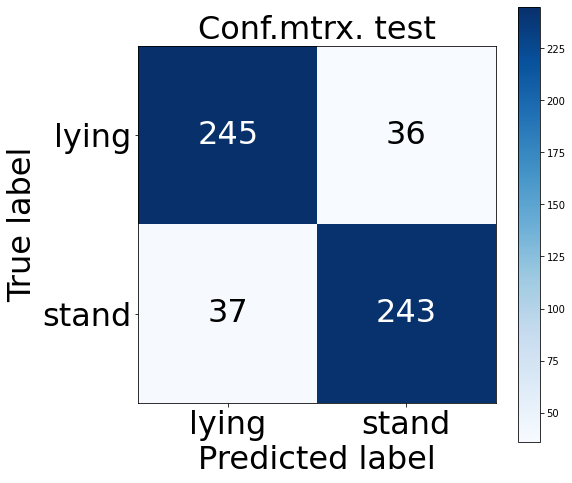

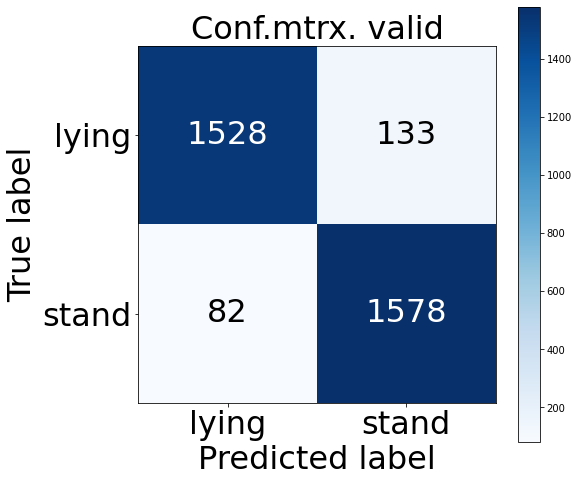

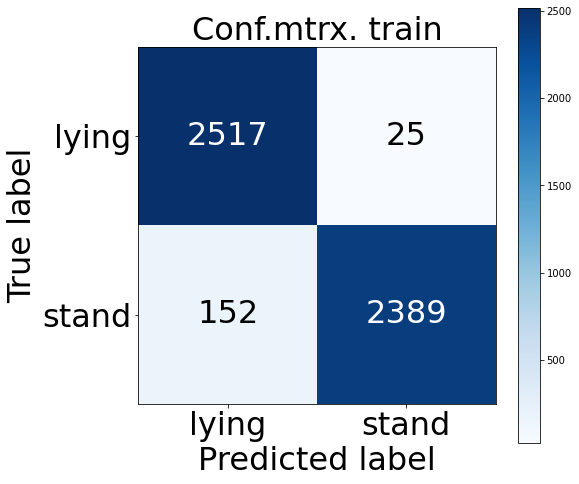

In [18]:
import scikitplot as skplt

for key, value in all_set_list_true.items():
    tmp_true=[]
    tmp_pred=[]
    tmp_true = [classes[i] for i in all_set_list_true[key]]
    tmp_pred = [classes[i] for i in all_set_list_pred[key]]
    skplt.metrics.plot_confusion_matrix(tmp_true, tmp_pred,figsize=(8,8),title_fontsize=32,text_fontsize=32, title= 'Conf.mtrx. '+key)

### 4 Вывод неправильно склассифицированых картинок, с сортировкой по убыванию веростностям

In [16]:
def plot_most_incorrect(key_set, width_size):
    for i in range(0, len(all_set_list_wrong[key_set]), width_size):
        if i+width_size>len(all_set_list_wrong[key_set]):
            yacheek=len(all_set_list_wrong[key_set])%width_size
        else:
            yacheek=width_size
        fig, axes = plt.subplots(nrows = 1, ncols =yacheek,figsize = (15, 15) )
        for idx, ax in enumerate(axes.flat):

            tmp_path=all_set_list_wrong[key_set][i+idx]['path']
            temp_prob=all_set_list_wrong[key_set][i+idx]['prob']
            true_label=all_set_list_wrong[key_set][i+idx]['true_label']
            model_answer=all_set_list_wrong[key_set][i+idx]['model_answer']
            ax.set_title(f'true label:' +classes[true_label]+'\n' \
                         f'pred label:'+classes[model_answer]+str(temp_prob)+'\n' \
                         f'name_file '+tmp_path[1+tmp_path.rfind('/'):])
            photo=plt.imread(tmp_path)
            ax.imshow(photo)
            ax.axis('off')
        plt.show()

In [ ]:
plot_most_incorrect('test_set',3) # Подставить из сет: 'test_set','valid_set','train_set'

In [ ]:
def plot_most_correct(key_set, width_size):
    for i in range(0, len(all_set_list_right[key_set]), width_size):
        if i+width_size>len(all_set_list_right[key_set]):
            yacheek=len(all_set_list_right[key_set])%width_size
        else:
            yacheek=width_size
        fig, axes = plt.subplots(nrows = 1, ncols =yacheek,figsize = (15, 15) )
        for idx, ax in enumerate(axes.flat):

            tmp_path=all_set_list_right[key_set][i+idx]['path']
            temp_prob=all_set_list_right[key_set][i+idx]['prob']
            true_label=all_set_list_right[key_set][i+idx]['true_label']
            model_answer=all_set_list_right[key_set][i+idx]['model_answer']
            ax.set_title(f'true label:' +classes[true_label]+'\n' \
                         f'pred label:'+classes[model_answer]+str(temp_prob)+'\n' \
                         f'name_file '+tmp_path[1+tmp_path.rfind('/'):])
            photo=plt.imread(tmp_path)
            ax.imshow(photo)
            ax.axis('off')
        plt.show()

In [ ]:
plot_most_correct('test_set',4) # Подставить из сет: 'test_set','valid_set','train_set'